In [19]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models

In [20]:
sample_rate = 16000
train_clean_dir = '../Dataset/train/train-clean/'
train_noisy_dir = '../Dataset/train/train-noisy/'
test_clean_dir = '../Dataset/test/test-clean/'
test_noisy_dir = '../Dataset/test/test-noisy/'

In [21]:
def load_audio_files(directory):
    file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.wav')]
    return file_paths

In [22]:
X_train_files = load_audio_files(train_clean_dir)
y_train_files = load_audio_files(train_noisy_dir)

In [23]:
def pad_or_truncate(spectrogram, target_shape=(1024, 160)):
    pad_width = [(0, max(0, target_shape[0] - spectrogram.shape[0])), 
                 (0, max(0, target_shape[1] - spectrogram.shape[1]))]
    
    if spectrogram.shape[0] > target_shape[0]:
        spectrogram = spectrogram[:target_shape[0], :]
    if spectrogram.shape[1] > target_shape[1]:
        spectrogram = spectrogram[:, :target_shape[1]]
    
    return np.pad(spectrogram, pad_width, mode='constant')

In [24]:
def compute_spectrograms_with_padding(file_paths, target_shape=(1024, 160)):
    spectrograms = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=sample_rate)
        spectrogram = librosa.stft(audio, n_fft=2048, hop_length=512)
        spectrogram = np.abs(spectrogram)
        spectrogram = pad_or_truncate(spectrogram, target_shape)
        spectrograms.append(spectrogram)
    return np.array(spectrograms)

In [25]:
X_train_spectrograms = compute_spectrograms_with_padding(X_train_files)
y_train_spectrograms = compute_spectrograms_with_padding(y_train_files)

/var/folders/yz/1fd13cns6gvbhv48blbqlsjh0000gn/T/ipykernel_96934/2660601794.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(file_path, sr=sample_rate)
/Users/johannasmriti/Documents/CSE 290D/Adding Noise to Dataset/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [26]:
os.makedirs('spectrogram_data', exist_ok=True)
np.save('spectrogram_data/X_train_spectrograms.npy', X_train_spectrograms)
np.save('spectrogram_data/y_train_spectrograms.npy', y_train_spectrograms)

In [27]:
class SpectrogramDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_data, y_data, batch_size):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X_data) / self.batch_size))

    def __getitem__(self, idx):
        batch_X = self.X_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.expand_dims(batch_X, -1), np.expand_dims(batch_y, -1)

X_train_spectrograms = np.load('spectrogram_data/X_train_spectrograms.npy')
y_train_spectrograms = np.load('spectrogram_data/y_train_spectrograms.npy')

batch_size = 5
train_generator = SpectrogramDataGenerator(X_train_spectrograms, y_train_spectrograms, batch_size=batch_size)

In [28]:
from tensorflow.keras import models, layers

def build_denoising_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    # Encoder
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Bottleneck
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

    # Decoder
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (1024, 160, 1)
model = build_denoising_model(input_shape)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 1024, 160, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 512, 80, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 512, 80, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 256, 40, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 256, 40, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 20, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 20, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 128, 20, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 20, 128)   │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 256, 40, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 40, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 512, 80, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 512, 80, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 1024, 160, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 1024, 160, 1)   │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,365,505 (5.21 MB)

 Trainable params: 1,365,505 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
epochs = 20
model.fit(train_generator, epochs=epochs)

Epoch 1/20


/Users/johannasmriti/Documents/CSE 290D/Adding Noise to Dataset/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


170/170 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - loss: 13.6055 - mae: 1.0101
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - loss: 13.5376 - mae: 0.8938
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 168s 986ms/step - loss: 14.0960 - mae: 0.9036
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - loss: 14.1092 - mae: 0.9054
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - loss: 14.5137 - mae: 0.8837
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - loss: 15.1233 - mae: 0.9115
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - loss: 13.7879 - mae: 0.8610
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - loss: 14.0539 - mae: 0.8763
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - loss: 13.8250 - mae: 0.8697
Epoch 10/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - loss: 14.5240 - mae: 0.9032
Epoch 11/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 166s 979ms/step - loss: 14.1700 - mae: 0.8695
Epoch 12/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3437s 20s/step - loss: 13.3639 - mae: 0.8338
Epoc

In [13]:
# Load test data
X_test_files = load_audio_files(test_clean_dir)
y_test_files = load_audio_files(test_noisy_dir)

# Compute test spectrograms
X_test_spectrograms = compute_spectrograms_with_padding(X_test_files)
y_test_spectrograms = compute_spectrograms_with_padding(y_test_files)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test_spectrograms[..., np.newaxis], y_test_spectrograms[..., np.newaxis])
print(f"Test Loss: {test_loss}")

/var/folders/yz/1fd13cns6gvbhv48blbqlsjh0000gn/T/ipykernel_96934/2660601794.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(file_path, sr=sample_rate)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step - accuracy: 1.1275e-07 - loss: -1539.2306
Test Loss: [-1546.278076171875, 8.138020746173424e-08]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


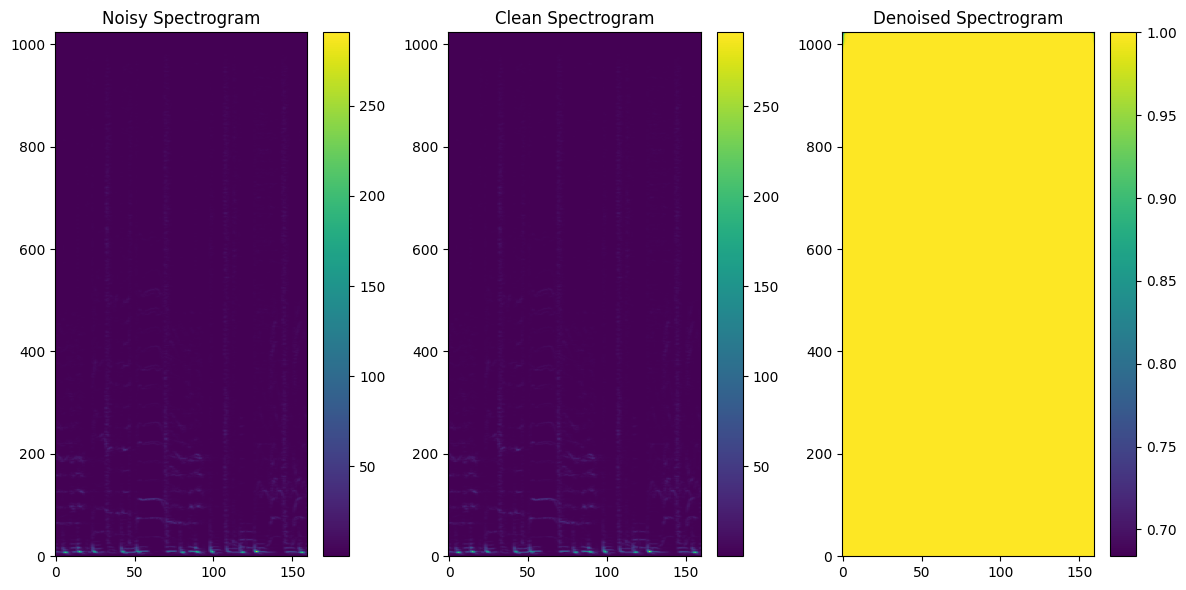

In [14]:
import matplotlib.pyplot as plt

# Select a sample from the test set
sample_index = 0
noisy_sample = X_test_spectrograms[sample_index]
clean_sample = y_test_spectrograms[sample_index]

# Make a prediction
predicted_sample = model.predict(noisy_sample[np.newaxis, ..., np.newaxis])

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Noisy Spectrogram")
plt.imshow(noisy_sample.squeeze(), aspect='auto', origin='lower')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Clean Spectrogram")
plt.imshow(clean_sample.squeeze(), aspect='auto', origin='lower')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Denoised Spectrogram")
plt.imshow(predicted_sample.squeeze(), aspect='auto', origin='lower')
plt.colorbar()

plt.tight_layout()
plt.show()

In [15]:
model.save('denoising_model.h5')

In [16]:
from sklearn.metrics import mean_squared_error

def psnr(target, ref):
    mse = mean_squared_error(target, ref)
    return 10 * np.log10((255 ** 2) / mse)

# Example for a sample
sample_psnr = psnr(clean_sample, predicted_sample.squeeze())
print(f"Sample PSNR: {sample_psnr:.2f} dB")


Sample PSNR: 33.14 dB
